Class = b'automobile'


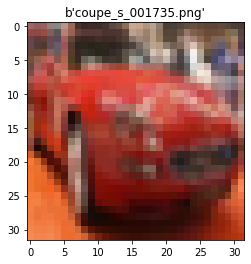

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Special function to read special files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Visualize the images in CIFAR-10 Dataset
## Here get_data unpickles the CIFAR Dataset and stores the data as 50000*3072 dimension in array X 
## and labels as 50000*1 dimension in array Y. 
## Visualize function shows the image corresponding to id number.

def get_data(file):
    my_dict = unpickle(file)
    X = my_dict[b'data']
    Y = my_dict[b'labels']
    names = np.asarray(my_dict[b'filenames'])
    list_class = (unpickle("cifar-10/batches.meta")[b'label_names'])
    return X, Y, names,list_class
                     

def visualize_image(X, Y, names, image_id):
    rgb = X[image_id,:]
    img = rgb.reshape(3, 32, 32).transpose([1, 2, 0])
    plt.imshow(img)
    plt.title(names[image_id])
    plt.show()

# Read images
imgs1, labels1, names1, classes1 = get_data("cifar-10/data_batch_1")
imgs2, labels2, names2, classes2 = get_data("cifar-10/data_batch_2")
imgs3, labels3, names3, classes3 = get_data("cifar-10/data_batch_3")
imgs4, labels4, names4, classes4 = get_data("cifar-10/data_batch_4")
imgs5, labels5, names5, classes5 = get_data("cifar-10/data_batch_5")

#concatenating all the images into imgs_train list 
imgs_train = np.concatenate((imgs1,imgs2,imgs3,imgs4,imgs5), axis=0)

#concatenating all the labels into labels_train list 
labels_train = np.concatenate((labels1,labels2,labels3,labels4,labels5), axis=0)

#concatenating all the names into names_train list 
names_train = np.concatenate((names1,names2,names3,names4,names5), axis=0)

#concatenating all the classes into classes_train list 
classes_train = np.concatenate((classes1,classes2,classes3,classes4,classes5), axis=0)

#reading the images that are used for testing
imgs_test, labels_test, names_test, classes_test = get_data("cifar-10/test_batch")

# Visualize the 5th image
pick = 5
print("Class =", classes_train[labels_train[pick]])
visualize_image(imgs_train, labels_train, names_train, pick)

In [3]:
imgs_train.shape

(50000, 3072)

In [4]:
def preprocess_train(imgs):
    
    #convert image array [50000 x 3072] to image [50000 x 32 x 32 x 3]
    imgs = imgs.reshape(imgs.shape[0], 3, 32, 32).transpose([0, 2, 3, 1])
    
    #convert to grayscale image [50000 x 32 x 32]
    imgs = np.dot(imgs[...,:3], [0.299, 0.587, 0.114])
    
    # If we are dealing with training images, compute the mean
    mean = np.mean(imgs, axis=0)
    
    #subtract by mean image
    imgs = imgs - mean
    
    #convert back to image array [50000 x 1024]
    print(imgs.shape)
    imgs = imgs.reshape(imgs.shape[0], 1024)
    print(imgs.shape)
    
    return imgs, mean

def preprocess_test(imgs, mean):
    
    #convert image array [50000 x 3072] to image [50000 x 32 x 32 x 3]
    imgs = imgs.reshape(imgs.shape[0], 3, 32, 32).transpose([0, 2, 3, 1])
    
    #convert to grayscale image [50000 x 32 x 32]
    imgs = np.dot(imgs[...,:3], [0.299, 0.587, 0.114])
    
    #subtract by mean image calculated from the training set
    imgs = imgs - mean
    
    #convert back to image array [50000 x 1024]
    print(imgs.shape)
    imgs = imgs.reshape(imgs.shape[0], 1024)
    print(imgs.shape)
    
    return imgs

In [5]:
# Preprocess the images
imgs_train, mean = preprocess_train(imgs_train)
imgs_test = preprocess_test(imgs_test, mean)

(50000, 32, 32)
(50000, 1024)
(10000, 32, 32)
(10000, 1024)


In [6]:
def find_eigenvalues_and_eigenvectors(A):
    # Your code here
    #C is the determinant of the matrix
    C = 1 / len(A) * np.dot(A.T, A)
    
    #this will compute eigenvalues and eigen vectors
    U, w, VT = np.linalg.svd(C, compute_uv=True)
    return w, U

In [7]:
#calling the above function 
eigenvalues_train, eigenvectors_train = find_eigenvalues_and_eigenvectors(imgs_train)
print(eigenvalues_train.shape)
print(eigenvectors_train.shape)
eigenvalues_test, eigenvectors_test = find_eigenvalues_and_eigenvectors(imgs_test)

(1024,)
(1024, 1024)


In [8]:
# REORDER

# Find the required order of indices to make decreasing order of eigenvalue
sort_index = np.argsort(eigenvalues_train)[::-1]

# Use the calculated order of indices to reorder eigenvalues and eigenvectors
eigenvalues_train = eigenvalues_train[sort_index]
eigenvectors_train = eigenvectors_train[:, sort_index]

# Find the required order of indices to make decreasing order of eigenvalue
sort_index = np.argsort(eigenvalues_test)[::-1]

# Use the calculated order of indices to reorder eigenvalues and eigenvectors
eigenvalues_test = eigenvalues_test[sort_index]
eigenvectors_est = eigenvectors_test[:, sort_index]


#see top 3 eigenvalues
print(eigenvalues_train[:3])
print(eigenvectors_train[:3])

[1145216.33719859  469187.86368005  275125.62506827]
[[-0.04930287 -0.03217863 -0.02858416 ...  0.00216022  0.00481356
   0.01851747]
 [-0.04918112 -0.03271296 -0.02820369 ... -0.00205114 -0.01104136
  -0.03790172]
 [-0.04927026 -0.03337433 -0.02792019 ...  0.00119292  0.01437492
   0.04834882]]


In [9]:
print(np.linalg.norm(eigenvectors_train[:,1]))    #checking if norm is 1
# NORMALIZE (no need to normalize when using SVD as it returns normalized eigenvectors)
# eigenvectors_train = eigenvectors_train / np.linalg.norm(eigenvectors_train, axis=0)

1.0000000000000009


In [10]:
eigenvectors_train.shape

(1024, 1024)

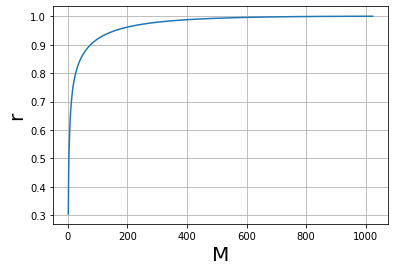

In [11]:
# Plot r vs M
# Values of M to consider: 1, 2,..., n
M = np.array(range(1, imgs_train.shape[1] + 1))

# Calculate r for all values of M
# Your code here
# Hint: Look for "numpy cumulative sum"
r = np.cumsum(eigenvalues_train)/np.sum(eigenvalues_train)

# Plot r vs M
plt.plot(M, r)
# We take only first 1024 eigenvectors because
# rest all correspond to eigen value 0
plt.xlabel("M", fontsize=20)
plt.ylabel("r", fontsize=20)
plt.grid("on")
plt.show()

In [12]:
r[25]

0.8009697910061453

In [13]:
N = 25

In [14]:
#pca_vectors_train has 25(value of N) eigen vectors from the training dataset 
pca_vectors_train = eigenvectors_train[:, :N]
#pca_vectors_test has 25(value of N) eigen vectors from the testing dataset 
pca_vectors_test = eigenvectors_test[:, :N]

In [15]:
#same like above but to find the pca features instead of eigen vectors
pca_features_train = np.dot(imgs_train, pca_vectors_train)
pca_features_test = np.dot(imgs_test, pca_vectors_test)

print(imgs_train.shape)
print(pca_features_train.shape)

(50000, 1024)
(50000, 25)


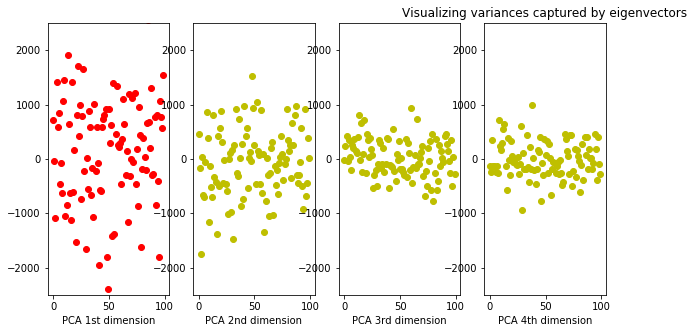

In [16]:
number_of_samples =  100
plt.figure(figsize=(10, 5))
plt.subplot(141)
plt.scatter(np.arange(number_of_samples), pca_features_train[:number_of_samples, 0], c='r')
plt.xlabel('PCA 1st dimension')
plt.ylim([-2500, 2500])
plt.subplot(142)
plt.scatter(np.arange(number_of_samples), pca_features_train[:number_of_samples, 1], c='y')
plt.xlabel('PCA 2nd dimension')
plt.ylim([-2500, 2500])
plt.subplot(143)
plt.scatter(np.arange(number_of_samples), pca_features_train[:number_of_samples, 3], c='y')
plt.xlabel('PCA 3rd dimension')
plt.ylim([-2500, 2500])
plt.subplot(144)
plt.scatter(np.arange(number_of_samples), pca_features_train[:number_of_samples, 4], c='y')
plt.xlabel('PCA 4th dimension')
plt.ylim([-2500, 2500])
plt.title('Visualizing variances captured by eigenvectors')
plt.show()

In [17]:
import math
import collections

#this function finds the euclidean distance between two points
def dist(a, b):
    sqSum = 0
    for i in range(len(a)):
        sqSum += (a[i] - b[i]) ** 2
    return math.sqrt(sqSum)


def kNN(k, train_features, train_labels, given_feature):
    distances = []
    for t in range(len(train_features)):
        distances.append((dist(train_features[t], given_feature), train_labels[t]))
    distances.sort()
    #return the sorted K neighbours distances
    return distances[:k]

def kNN_classify(k, train_features, train_labels, given_feature):
    #tally is an empty dictionary initially
    tally = collections.Counter()
    for nn in kNN(k, train_features, train_labels, given_feature):
        #stroing the integer value of the last column in the dataset in the tally
        tally.update(str(int(nn[-1])))
    #return the top most common among the K neighbours
    return int(tally.most_common(1)[0][0])

In [18]:
kNN_classify(3,  pca_features_train, labels_train, pca_features_test[1])

8

In [19]:
labels_test[1]

8

## Use kNN to classify the first 10 test images using pca_features

In [20]:
predicted_labels_test = []

# Predict labels on the test set
for i in range(10):
    print("Predicting", i+1, "of 10")
    predicted_labels_test.append(kNN_classify(3, pca_features_train, labels_train, pca_features_test[i]))

# Find accuracy
kNN_test_accuracy_pca = np.mean(np.array(predicted_labels_test) == np.array(labels_test[:10]))
print("Accuracy =", kNN_test_accuracy_pca)

Predicting 1 of 10
Predicting 2 of 10
Predicting 3 of 10
Predicting 4 of 10
Predicting 5 of 10
Predicting 6 of 10
Predicting 7 of 10
Predicting 8 of 10
Predicting 9 of 10
Predicting 10 of 10
Accuracy = 0.2


In [21]:
predicted_labels_test

[4, 8, 0, 8, 6, 2, 6, 3, 0, 6]

In [22]:
labels_test[:10]

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1]

In [23]:
values_of_N = [5, 10, 15, 20, 25]
for N in values_of_N:
    print("N = " + str(N))
    pca_vectors_train = eigenvectors_train[:, :N]
    pca_vectors_test = eigenvectors_test[:, :N]

    pca_features_train = np.dot(imgs_train, pca_vectors_train)
    pca_features_test = np.dot(imgs_test, pca_vectors_test)

    print(imgs_train.shape)
    print(pca_features_train.shape)
    predicted_labels_test = []

    # Predict labels on the test set
    for i in range(10):
        print("Predicting", i+1, "of 10")
        predicted_labels_test.append(kNN_classify(3, pca_features_train, labels_train, pca_features_test[i]))

    # Find accuracy
    kNN_test_accuracy_pca = np.mean(np.array(predicted_labels_test) == np.array(labels_test[:10]))
    print("Accuracy =", kNN_test_accuracy_pca)

N = 5
(50000, 1024)
(50000, 5)
Predicting 1 of 10
Predicting 2 of 10
Predicting 3 of 10
Predicting 4 of 10
Predicting 5 of 10
Predicting 6 of 10
Predicting 7 of 10
Predicting 8 of 10
Predicting 9 of 10
Predicting 10 of 10
Accuracy = 0.0
N = 10
(50000, 1024)
(50000, 10)
Predicting 1 of 10
Predicting 2 of 10
Predicting 3 of 10
Predicting 4 of 10
Predicting 5 of 10
Predicting 6 of 10
Predicting 7 of 10
Predicting 8 of 10
Predicting 9 of 10
Predicting 10 of 10
Accuracy = 0.3
N = 15
(50000, 1024)
(50000, 15)
Predicting 1 of 10
Predicting 2 of 10
Predicting 3 of 10
Predicting 4 of 10
Predicting 5 of 10
Predicting 6 of 10
Predicting 7 of 10
Predicting 8 of 10
Predicting 9 of 10
Predicting 10 of 10
Accuracy = 0.3
N = 20
(50000, 1024)
(50000, 20)
Predicting 1 of 10
Predicting 2 of 10
Predicting 3 of 10
Predicting 4 of 10
Predicting 5 of 10
Predicting 6 of 10
Predicting 7 of 10
Predicting 8 of 10
Predicting 9 of 10
Predicting 10 of 10
Accuracy = 0.3
N = 25
(50000, 1024)
(50000, 25)
Predicting 1 